### dataset

In [ ]:
! pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d yakhyokhuja/webface-112x112 -p /content

Dataset URL: https://www.kaggle.com/datasets/yakhyokhuja/webface-112x112
License(s): unknown


In [ ]:
!kaggle datasets download -d jessicali9530/lfw-dataset -p /content

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other


In [ ]:
import zipfile
import os

zip_path = "/content/webface-112x112.zip"  # Update if needed
extract_to = "/content/webface-112x112"

# Unzip with progress
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Dataset extracted successfully!")


✅ Dataset extracted successfully!


In [ ]:
import os
from pathlib import Path

root = Path('/content/webface-112x112/webface_112x112')
min_images = 5

for identity_dir in root.iterdir():
    if identity_dir.is_dir():
        img_count = len(list(identity_dir.glob('*.jpg')))
        if img_count < min_images:
            print(f"Removing {identity_dir.name} with {img_count} images")
            shutil.rmtree(identity_dir)


FileNotFoundError: [Errno 2] No such file or directory: '/content/webface-112x112/webface_112x112'

In [ ]:
!pip install opencv-python matplotlib numpy


### face alignement

In [ ]:
pip install retina-face opencv-python


src_root = Path('/content/vggface2/train')  # Original dataset
dst_root = Path('/content/vggface2_aligned/train')  # Aligned images

### insightface

In [ ]:
!pip install -q torch torchvision numpy opencv-python scikit-learn tqdm
!git clone https://github.com/deepinsight/insightface.git
%cd insightface
!pip install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
Cloning into 'insightface'...
remote: Enumerating objects: 12085, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 12085 (delta 49), reus

In [ ]:
# Dataset setup (modify path if using Google Drive)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(root='/content/vggface2/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)


In [ ]:
# ArcFace Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logit = torch.cos(theta + self.m)
        one_hot = F.one_hot(label, num_classes=cosine.shape[1]).float()
        output = cosine * (1 - one_hot) + target_logit * one_hot
        output *= self.s
        return output

In [ ]:
#!pip uninstall -y insightface
!pip install -q onnxruntime
!git clone https://github.com/deepinsight/insightface.git
%cd insightface
!pip install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00
Cloning into 'insightface'...
remote: Enumerating objects: 12085, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 12085 (delta 49), reused 39 (delta 39), pack-reused 12007 (from 3)
Receiving objects: 100% (12085/12085), 57.34 MiB | 29.92 MiB/s, done.
Resolving deltas: 100% (6160/6160), done.
/content/insightface/insightface
Obtaining file:///content/insightface/insightface
ERROR: file:///content/insightface/insightface does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
import insightface
from insightface.app import FaceAnalysis

# Step 3: Initialize face embedding model
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])  # or use 'CPUExecutionProvider'
app.prepare(ctx_id=0, det_size=(640, 640))  # Set ctx_id=-1 if no GPU

ModuleNotFoundError: No module named 'insightface.app'

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Load a face image (aligned or unaligned — detection is included)
img = cv2.imread('/content/Baby-Face-02.jpg')
img2 = cv2.imread('/content/real_1008.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Detect and extract face embeddings
faces = app.get(img)

if faces:
    emb = faces[0].embedding
    print("Embedding shape:", emb.shape, emb)

    # Optional: visualize
    plt.imshow(img_rgb)
    plt.title("Detected Face")
    plt.axis("off")
    plt.show()
else:
    print("No face detected.")

faces = app.get(img2)

if faces:
    emb2 = faces[0].embedding
    print("Embedding shape:", emb2.shape, emb2)

    # Optional: visualize
    plt.imshow(img2_rgb)
    plt.title("Detected Face")
    plt.axis("off")
    plt.show()
else:
    print("No face detected.")


NameError: name 'app' is not defined

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity([emb], [emb2])[0][0]
print(f"Cosine Similarity: {similarity}")

Cosine Similarity: 0.8008074164390564


### custom cnn ResNet backbone with Arcface

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


resnet

In [ ]:
import torch.nn as nn
import torch
import math

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, layers, num_classes=1000, model_path="model.pkl"):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.modelPath = model_path

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stack1 = self._make_layer(64, layers[0])
        self.stack2 = self._make_layer(128, layers[1], stride=2)
        self.stack3 = self._make_layer(256, layers[2], stride=2)
        self.stack4 = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # safer than fixed-size
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion)
            )

        layers = [Bottleneck(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * Bottleneck.expansion

        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.stack1(x)
        x = self.stack2(x)
        x = self.stack3(x)
        x = self.stack4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# === Convenience functions ===

def resnet50(pretrained=False, num_classes=1000, model_path="model.pkl"):
    model = ResNet([3, 4, 6, 3], num_classes=num_classes, model_path=model_path)
    if pretrained:
        model.load_state_dict(torch.load(model_path), strict=False)
    return model

def resnet101(pretrained=False, num_classes=1000, model_path="model.pkl"):
    model = ResNet([3, 4, 23, 3], num_classes=num_classes, model_path=model_path)
    if pretrained:
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


In [ ]:
vgg

In [ ]:
import torch
import torch.nn as nn
import math

def vgg16(pretrained=False, number_classes=2000, model_path="model.pkl"):
    model = VGG(number_classes=number_classes, model_path=model_path)
    if pretrained:
        model.load_state_dict(torch.load(model_path), strict=False)
    return model

class VGG(nn.Module):
    def __init__(self, number_classes=2000, model_path="model.pkl"):
        super(VGG, self).__init__()
        self.modelPath = model_path

        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # safer than fixed size

        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, number_classes)

        self._init_params()

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.shape[0] * m.weight.shape[1]
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))
        x = self.maxpool(x)

        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.maxpool(x)

        x = self.relu(self.conv31(x))
        x = self.relu(self.conv32(x))
        x = self.relu(self.conv33(x))
        x = self.maxpool(x)

        x = self.relu(self.conv41(x))
        x = self.relu(self.conv42(x))
        x = self.relu(self.conv43(x))
        x = self.maxpool(x)

        x = self.relu(self.conv51(x))
        x = self.relu(self.conv52(x))
        x = self.relu(self.conv53(x))
        x = self.maxpool(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import os
import shutil

# Set your target directory here
target_dir = '/content/webface-112x112/webface_112x112'

# Get all subdirectories
subdirs = [d for d in os.listdir(target_dir) if os.path.isdir(os.path.join(target_dir, d))]

# Sort subdirectories (you can use key=os.path.getmtime for sorting by modified time)
subdirs.sort()

# Get the last 3911 subdirectories
to_delete = subdirs[-3911:]

# Delete them
for folder in to_delete:
    folder_path = os.path.join(target_dir, folder)
    print(f"Deleting: {folder_path}")
    shutil.rmtree(folder_path)

print("✅ Done deleting folders.")


Deleting: /content/webface-112x112/webface_112x112/id_6479
Deleting: /content/webface-112x112/webface_112x112/id_648
Deleting: /content/webface-112x112/webface_112x112/id_6480
Deleting: /content/webface-112x112/webface_112x112/id_6481
Deleting: /content/webface-112x112/webface_112x112/id_6482
Deleting: /content/webface-112x112/webface_112x112/id_6483
Deleting: /content/webface-112x112/webface_112x112/id_6484
Deleting: /content/webface-112x112/webface_112x112/id_6485
Deleting: /content/webface-112x112/webface_112x112/id_6486
Deleting: /content/webface-112x112/webface_112x112/id_6487
Deleting: /content/webface-112x112/webface_112x112/id_6488
Deleting: /content/webface-112x112/webface_112x112/id_6489
Deleting: /content/webface-112x112/webface_112x112/id_649
Deleting: /content/webface-112x112/webface_112x112/id_6490
Deleting: /content/webface-112x112/webface_112x112/id_6491
Deleting: /content/webface-112x112/webface_112x112/id_6492
Deleting: /content/webface-112x112/webface_112x112/id_6493

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class ImageData(Dataset):
    def __init__(self, root_path="CACD2000/", label_path="data/label.npy", name_path="data/name.npy", train_mode="train"):
        """
        Initialize some variables
        Load labels & names
        define transform
        """
        self.root_path = root_path
        self.image_labels = np.load(label_path)
        self.image_names = np.load(name_path)
        self.train_mode = train_mode
        self.transform = {
            'train': transforms.Compose([
                transforms.Resize(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
            ]),
        }

    def __len__(self):
        """
        Get the length of the entire dataset
        """
        print("Length of dataset is ", self.image_labels.shape[0])
        return self.image_labels.shape[0]

    def __getitem__(self, idx):
        """
        Get the image item by index
        """
        image_name = os.path.join(self.root_path, self.image_names[idx])
        image = Image.open(image_name)
        image_label = self.image_labels[idx].astype(int) - 1
        transformed_img = self.transform[self.train_mode](image)
        sample = {'image': transformed_img, 'label': torch.from_numpy(image_label)}
        return sample

# Now, modify to use ImageFolder for loading data
train_dataset = datasets.ImageFolder('/content/webface-112x112/webface_112x112', transform=transform_train)
val_dataset = datasets.ImageFolder('/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Number of classes is based on the dataset
num_classes = len(train_dataset.classes)

# Example of iterating through the DataLoader
for inputs, labels in train_loader:
    print(inputs.size(), labels.size())
    break  # Just to check one batch


print("✅ Dataset loaded successfully!")
print(f"Number of training identities: {len(train_dataset.classes)}")
print(f"Number of validation identities: {len(val_dataset.classes)}")
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")


torch.Size([64, 3, 112, 112]) torch.Size([64])
✅ Dataset loaded successfully!
Number of training identities: 6661
Number of validation identities: 5749
Total training images: 336579
Total validation images: 13233


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# === CONFIG ===
model_name = "resnet50"
num_classes = 2000
root_train_path = "/content/webface-112x112/webface_112x112"  # Path to training data
root_val_path = "/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"  # Path to validation data
model_path = "model.pkl"
load_pretrained = False  # Set to True if you want to load pretrained weights
num_epochs = 10
batch_size = 32
learning_rate = 0.001
batch_display = 50
save_freq = 1

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === DATASET ===
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=root_train_path, transform=transform_train)
val_dataset = datasets.ImageFolder(root=root_val_path, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# === RESNET IMPLEMENTATION ===
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, layers, num_classes=1000, model_path="model.pkl"):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.modelPath = model_path

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stack1 = self._make_layer(64, layers[0])
        self.stack2 = self._make_layer(128, layers[1], stride=2)
        self.stack3 = self._make_layer(256, layers[2], stride=2)
        self.stack4 = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # safer than fixed-size
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion)
            )

        layers = [Bottleneck(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * Bottleneck.expansion

        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.stack1(x)
        x = self.stack2(x)
        x = self.stack3(x)
        x = self.stack4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# === Convenience functions ===

def resnet50(pretrained=False, num_classes=1000, model_path="model.pkl"):
    model = ResNet([3, 4, 6, 3], num_classes=num_classes, model_path=model_path)
    if pretrained:
        model.load_state_dict(torch.load(model_path), strict=False)
    return model

# Ensure the model is moved to the GPU
model = resnet50(pretrained=load_pretrained, num_classes=num_classes, model_path=model_path)
model = model.to(device)  # Move model to GPU if available

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0

    for i_batch, (images, labels) in enumerate(train_loader):
        # Move to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Debugging: Print label range and shape
        print(f"Labels range: {labels.min()} - {labels.max()}")
        print(f"Labels shape: {labels.shape}")

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Check if any NaNs or infs in outputs
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("Warning: NaN or Inf in outputs")
            continue

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if i_batch % batch_display == 0:
            _, preds = torch.max(outputs, dim=1)
            correct = (preds == labels).sum().item() / batch_size
            print(f"Epoch {epoch}, Batch {i_batch}, Loss: {loss.item():.4f}, Accuracy: {correct:.4f}")

    avg_loss = total_loss * batch_size / num_batches
    print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.4f}")

    # === Save Model ===
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), model_path)

Using device: cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision.models as models

# Load the local image directly
img_path = "/content/2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg"
img = Image.open(img_path).convert('RGB')  # Convert to RGB just in case

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Load pretrained ResNet-50
model = models.resnet50(pretrained=True).eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
img_tensor = img_tensor.to(device)

# Run inference
with torch.no_grad():
    outputs = model(img_tensor)
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

# Get class labels
import requests
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.strip().split("\n")

# Show top 5 predictions
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(f"{labels[top5_catid[i]]}: {top5_prob[i].item():.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


minivan: 0.2089
sports car: 0.1947
car wheel: 0.1911
grille: 0.1800
beach wagon: 0.1749


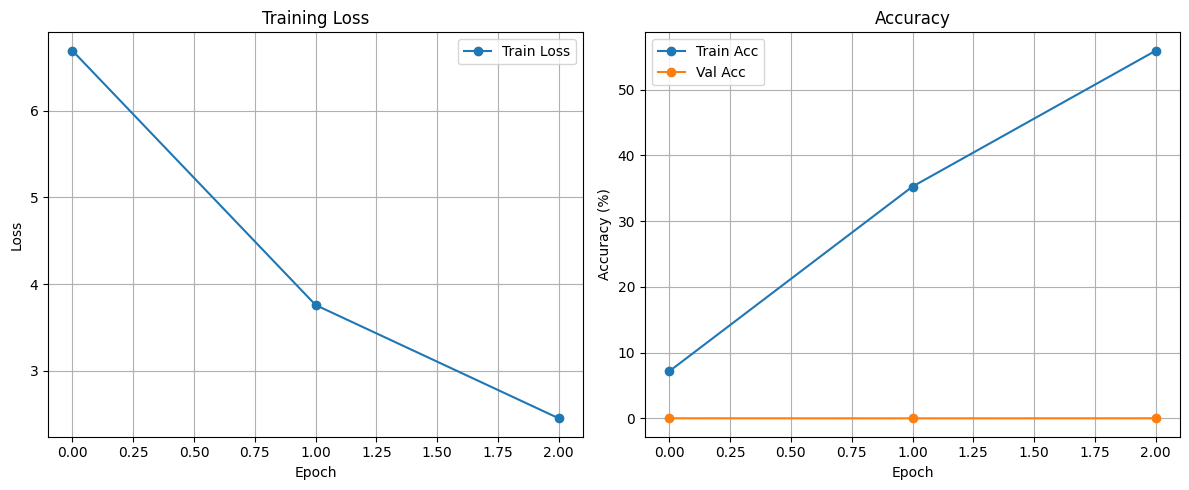

In [ ]:
# Plot loss and accuracy trends
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(val_accuracies, label='Val Acc', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### check

In [ ]:

for i in range(5):
    img, label = train_dataset[i]
    print(f"Sample {i}: Label = {label}")

for i in range(3):
    print(train_dataset[i][1], val_dataset[i][1])
print(val_dataset.classes)



Sample 0: Label = 0
Sample 1: Label = 0
Sample 2: Label = 0
Sample 3: Label = 0
Sample 4: Label = 0
0 0
0 1
0 2
['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase',

In [ ]:
# Check a few samples to verify label assignment
for i in range(5000,5005):
    img, label = train_dataset[i]
    class_name = train_dataset.classes[label]
    print(f"Sample {i}: Label = {label} (Class Name = {class_name})")


Sample 5000: Label = 126 (Class Name = id_1011)
Sample 5001: Label = 126 (Class Name = id_1011)
Sample 5002: Label = 126 (Class Name = id_1011)
Sample 5003: Label = 126 (Class Name = id_1011)
Sample 5004: Label = 126 (Class Name = id_1011)


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Check a few images
for i in range(600,605):
    img, label = train_dataset[i]
    plt.imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC for display
    plt.title(f"Label: {train_dataset.classes[label]}")
    plt.show()


Sample 0: Label = 0 (Class Name = n000002)
Sample 1: Label = 0 (Class Name = n000002)
Sample 2: Label = 0 (Class Name = n000002)
Sample 3: Label = 0 (Class Name = n000002)
Sample 4: Label = 0 (Class Name = n000002)


In [ ]:
for images, labels in train_loader:
    print(labels[:5])  # Check the first 5 labels
    break


tensor([4266, 3433, 6050, 9384, 4438])


In [ ]:
!ls /content/vggface2/train


n000002  n000059  n000116  n000175  n000231  n000287  n000341  n000397	n000454
n000003  n000060  n000117  n000176  n000232  n000288  n000342  n000398	n000455
n000004  n000061  n000118  n000177  n000233  n000289  n000343  n000399	n000456
n000005  n000062  n000119  n000179  n000234  n000290  n000344  n000400	n000457
n000006  n000063  n000120  n000180  n000235  n000291  n000345  n000401	n000458
n000007  n000064  n000121  n000181  n000236  n000292  n000346  n000402	n000459
n000008  n000065  n000122  n000182  n000237  n000293  n000347  n000403	n000460
n000010  n000066  n000123  n000183  n000238  n000294  n000348  n000405	n000461
n000011  n000067  n000124  n000184  n000239  n000295  n000349  n000406	n000462
n000012  n000068  n000125  n000185  n000240  n000296  n000350  n000407	n000463
n000013  n000069  n000126  n000186  n000241  n000297  n000351  n000408	n000464
n000014  n000070  n000127  n000187  n000242  n000298  n000352  n000409	n000465
n000015  n000071  n000128  n000188  n000243  n000299

###fjef

In [ ]:
import cv2
import numpy as np
import os
import sys
import time

# Add a small delay to ensure pip install completes
time.sleep(5)

# Try importing insightface after installation
try:
    from insightface.app import FaceAnalysis
    from insightface.data import get_image as ins_get_image
except ImportError:
    print("Attempting to install insightface with specific version...")
    !pip install insightface==0.7.3
    time.sleep(5)
    from insightface.app import FaceAnalysis
    from insightface.data import get_image as ins_get_image

# Initialize the FaceAnalysis application
# Download models if needed
os.makedirs('~/.insightface/models', exist_ok=True)
app = FaceAnalysis(name='buffalo_l', root='~/.insightface/models')
app.prepare(ctx_id=0, det_size=(640, 640))  # Using GPU 0, detection size 640x640

def get_face_embedding(image_path):
    """
    Extract face embedding from an image using ArcFace

    Args:
        image_path: path to the image file

    Returns:
        embedding: face embedding vector (512-dimensional)
        None if no face is detected
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image from {image_path}")
        return None

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect faces
    faces = app.get(img)

    if len(faces) == 0:
        print("No face detected in the image")
        return None

    # Get the largest face if multiple faces are detected
    if len(faces) > 1:
        print(f"Multiple faces detected, using the largest one")
        # Sort faces by area (bbox size)
        faces = sorted(faces, key=lambda x: (x.bbox[2]-x.bbox[0])*(x.bbox[3]-x.bbox[1]), reverse=True)

    # Extract face embedding
    face = faces[0]
    embedding = face.embedding

    # Normalize the embedding (optional, but recommended for cosine similarity comparisons)
    embedding = embedding / np.linalg.norm(embedding)

    return embedding

# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = "/content/ranim.png"

    # Get the face embedding
    embedding = get_face_embedding(image_path)
    print(embedding)
    if embedding is not None:
        print(f"Face embedding shape: {embedding.shape}")
        print(f"Face embedding (first 10 values): {embedding[:10]}")

        # Save the embedding to a file
        np.save("ranim.npy", embedding)
        print("Embedding saved to hazem.npy")

        # To measure similarity between two face embeddings:
        # similarity = np.dot(embedding1, embedding2)
        # The closer to 1, the more similar the faces are

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

In [ ]:
!pip install insightface opencv-python numpy onnxruntime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 120.2 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1064783 sha256=a3b974ba9f15c89a7b8a9d99c7c5bc85dcdcae9314bf202a84db6aca0e3e992f
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=2429acdda6640bfdae94d227d7e0e268cec229053328d026b99b1b58d7e46c4f
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
import os
import numpy as np
from deepface import DeepFace
import cv2

def get_face_embedding(image_path, model_name="ArcFace"):
    """
    Extract face embedding from an image using various face recognition models

    Args:
        image_path: path to the image file
        model_name: name of the model to use (ArcFace, Facenet, Facenet512, OpenFace, etc.)

    Returns:
        embedding: face embedding vector
        None if no face is detected
    """
    try:
        # DeepFace embedding extraction already handles face detection
        embedding_obj = DeepFace.represent(
            img_path=image_path,
            model_name=model_name,
            detector_backend='retinaface'
        )

        # Get the embedding
        if embedding_obj and len(embedding_obj) > 0:
            embedding = np.array(embedding_obj[0]['embedding'])

            # Normalize the embedding
            embedding = embedding / np.linalg.norm(embedding)
            return embedding
        else:
            print("No face detected in the image")
            return None

    except Exception as e:
        print(f"Error extracting face embedding: {str(e)}")
        return None

# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = "/content/real_1008.jpg"

    # Get the face embedding using ArcFace
    embedding = get_face_embedding(image_path, model_name="ArcFace")

    if embedding is not None:
        print(f"Face embedding shape: {embedding.shape}")
        print(embedding)

        # Save the embedding to a file
        np.save("face_embedding.npy", embedding)
        print("Embedding saved to face_embedding.npy")

        # To measure similarity between two face embeddings:
        # similarity = np.dot(embedding1, embedding2)
        # The closer to 1, the more similar the faces ar

25-04-28 14:58:26 - Directory /root/.deepface has been created
25-04-28 14:58:26 - Directory /root/.deepface/weights has been created
25-04-28 14:58:27 - arcface_weights.h5 will be downloaded to /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:00<00:00, 263MB/s]
Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5


25-04-28 14:58:31 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


100%|██████████| 119M/119M [00:00<00:00, 221MB/s]


Error extracting face embedding: Graph execution error:

Detected at node model/bn_data/FusedBatchNormV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/pyt